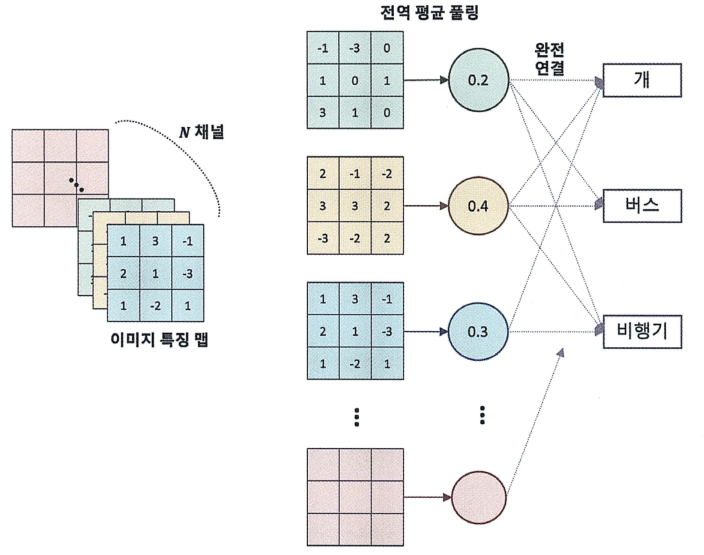 <br>
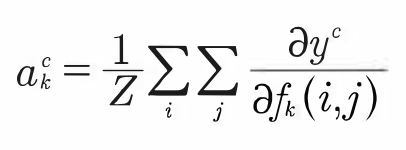 <br>
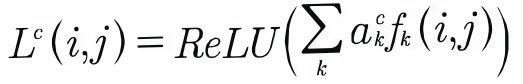

In [1]:
import torch


class GradCAM:
    def __init__(self, model, main, sub):
        self.model = model.eval()
        self.register_hook(main, sub)

    def register_hook(self, main, sub):
        # model.named_children() VS model.children()
        # 둘 다 top-level submodules 를 불러온다.
        # model.children(): 모듈 객체만 줌
        # model.named_children(): (이름, 모듈) 페어를 줌, 블록/레이어를 이름으로 특정해야 할 때 사용
        for name, module in self.model.named_children():
            if name == main:
                for sub_name, sub_module in module[-1].named_children(): #module[-1] 마지막 블럭만 탐색
                    if sub_name == sub:
                        #forward()가 끝난 직후 호출, feature map 저장
                        sub_module.register_forward_hook(self.forward_hook)
                        #역전파 중 해당 모듈의 gradient를 계산할 때 호출(loss,backward() 또는 output.backward()), gradient 캡처
                        sub_module.register_full_backward_hook(self.backward_hook)

    def forward_hook(self, module, input, output):
        #module, input은 여기서는 쓰이지 않지만
        #register_forward_hook 함수의 정의에 따라 있어야됨.
        self.feature_map = output  

    def backward_hook(self, module, grad_input, grad_output):
        #module, grad_input은 여기서는 쓰이지 않지만
        #register_backward_hook 함수의 정의에 따라 있어야됨.
        #
        #print(type(grad_output))   #tuple,  grad_output 이 tuple 인지 확인
        #print(len(grad_output))    #1,      grad_output 의 크기 확인
        #print(type(grad_output[0]))   #<class 'torch.Tensor'>
        #print(grad_output[0].shape)   #torch.Size([4, 512, 7, 7])
        self.gradient = grad_output[0] #grad_ouput은 tuple로 저장되어 있으므로 [0]으로 값을 불러옴
        
    def __call__(self, x):
        output = self.model(x)

        #추론 결과 one_hot vector(matrix) 만들기
        index = output.argmax(axis=1) #[404,874,236,275] 각 이미지 추론 결과 클래스
        one_hot = torch.zeros_like(output) #one_hot.shape = [4,1000]                
        for i in range(output.size(0)):
            one_hot[i][index[i]] = 1

        self.model.zero_grad()
        #gradient=one_hot: 정답 클래스에 대해서만 gradient 계산
        #retain_graph=True
        # 기본적으로 backward 후 연산 그래프는 해제됨
        # 같은 forward 결과로 backward를 한번 더 호출해야 할 필요가 있을 때 사용
        # 여기서는 한번만 호출하므로 False로 해도 무관
        output.backward(gradient=one_hot, retain_graph=True)

        # self.gradient.shape   # torch.Size([4, 512, 7, 7]) #feature map에 대응하는 gradient map
        # a_k.shape             # torch.Size([4, 512, 1, 1]) #gradient map의 평균
        a_k = torch.mean(self.gradient, dim=(2, 3), keepdim=True)
        grad_cam = torch.sum(a_k * self.feature_map, dim=1) #shape [4,7,7]
        grad_cam = torch.relu(grad_cam)
        return grad_cam

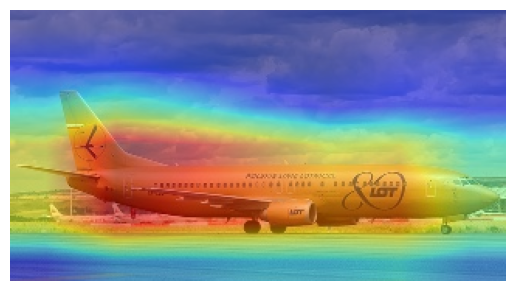

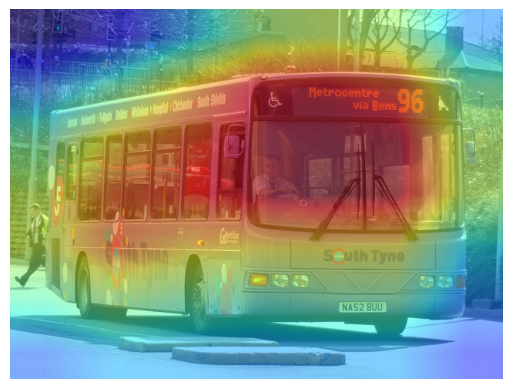

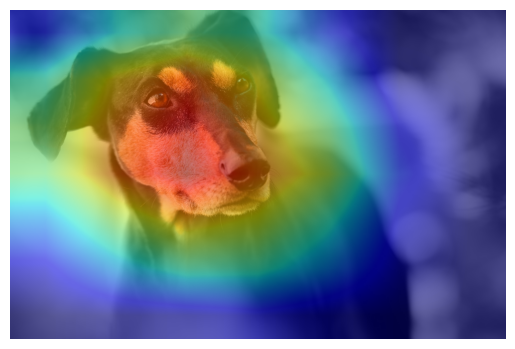

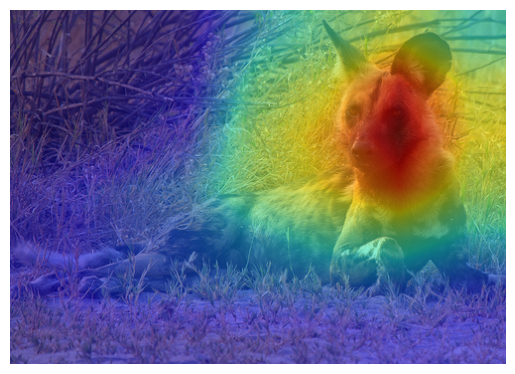

In [2]:
from PIL import Image
from torch.nn import functional as F
from torchvision import models
from torchvision import transforms
from matplotlib import pyplot as plt


transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
    ]
)

files = [
    "./datasets/images/airplane.jpg", "./datasets/images/bus.jpg",
    "./datasets/images/dog.jpg", "./datasets/images/african_hunting_dog.jpg"
]
images, tensors = [], []
for file in files:
    image = Image.open(file)
    images.append(image)
    tensors.append(transform(image))
tensors = torch.stack(tensors) #여러개의 텐서가 쌓인 리스트를, 텐서로 바꾼다.

model = GradCAM(
    model=models.resnet18(weights="ResNet18_Weights.IMAGENET1K_V1"),
    main="layer4",
    sub="conv2"
)
grad_cams = model(tensors)

for idx, image in enumerate(images):
    grad_cam = F.interpolate(
        input=grad_cams[idx].unsqueeze(0).unsqueeze(0),
        size=(image.size[1], image.size[0]),
        mode="bilinear",
    ).squeeze().detach().numpy()

    plt.imshow(image)
    plt.imshow(grad_cam, cmap="jet", alpha=0.5)
    plt.axis("off")
    plt.show()